In [94]:
%matplotlib inline
import numpy as np
import pandas as pd
import io
import requests
import seaborn as sns
from matplotlib import pyplot as plt
import pickle
import os
from pandas.api.types import CategoricalDtype
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score
%matplotlib inline

In [95]:
def load_dataset(path, urls):
    if not os.path.exists(path):
        os.mkdir(path)

    for url in urls:
        data = requests.get(url).content
        filename = os.path.join(path, os.path.basename(url))
        with open(filename, "wb") as file:
            file.write(data)

In [96]:
urls = ["http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
        "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names",
        "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"]
load_dataset('data', urls)

In [97]:
columns = ["age", "workClass", "fnlwgt", "education", "education-num","marital-status", "occupation", "relationship",
          "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]
train_data = pd.read_csv('data/adult.data', names=columns, sep=' *, *', na_values='?',engine='python')
test_data  = pd.read_csv('data/adult.test', names=columns, sep=' *, *', skiprows=1, na_values='?',engine='python')

In [98]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workClass         30725 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        30718 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    31978 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [99]:
num_attributes = train_data.select_dtypes(include=['float64'])
print(num_attributes.columns)

Index([], dtype='object')


In [101]:
num_attributes.hist(figsize=(10,10))


ValueError: num must be 1 <= num <= 0, not 1

<Figure size 720x720 with 0 Axes>

In [102]:
print(test_data.iloc[:3])

   age  workClass  fnlwgt   education  education-num      marital-status  \
0   25    Private  226802        11th              7       Never-married   
1   38    Private   89814     HS-grad              9  Married-civ-spouse   
2   28  Local-gov  336951  Assoc-acdm             12  Married-civ-spouse   

          occupation relationship   race   sex  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black  Male             0             0   
1    Farming-fishing      Husband  White  Male             0             0   
2    Protective-serv      Husband  White  Male             0             0   

   hours-per-week native-country  income  
0              40  United-States  <=50K.  
1              50  United-States  <=50K.  
2              40  United-States   >50K.  


In [103]:
train_data.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [104]:
cat_attributes = train_data.select_dtypes(include=['object'])
print(cat_attributes.columns)

Index(['workClass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country', 'income'],
      dtype='object')


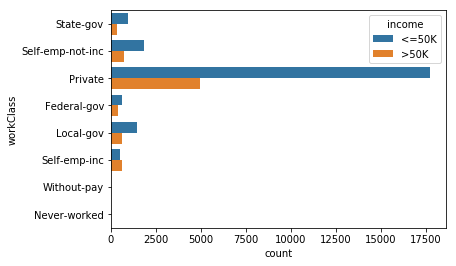

In [105]:
sns.countplot(y='workClass', hue='income', data = cat_attributes)

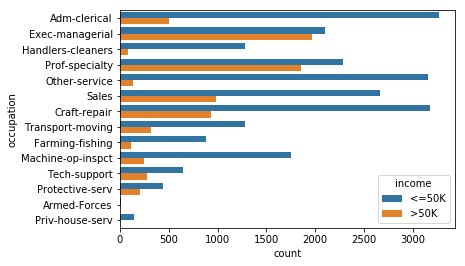

In [106]:
sns.countplot(y='occupation', hue='income', data = cat_attributes)

In [108]:
train_data.astype('object').describe().transpose()

,count,unique,top,freq
age,32561,73,36,898
workClass,30725,8,Private,22696
fnlwgt,32561,21648,203488,13
education,32561,16,HS-grad,10501
education-num,32561,16,9,10501
marital-status,32561,7,Married-civ-spouse,14976
occupation,30718,14,Prof-specialty,4140
relationship,32561,6,Husband,13193
race,32561,5,White,27816
sex,32561,2,Male,21790


In [109]:
class ColumnsSelector(BaseEstimator, TransformerMixin):
  
  def __init__(self, type):
    self.type = type
  
  def fit(self, X, y=None):
    return self
  
  def transform(self,X):
    return X.select_dtypes(include=[self.type])

In [110]:
num_pipeline = Pipeline(steps=[
    ("num_attr_selector", ColumnsSelector(type='int')),
    ("scaler", StandardScaler())
])

In [111]:
class CategoricalImputer(BaseEstimator, TransformerMixin):
  
  def __init__(self, columns = None, strategy='most_frequent'):
    self.columns = columns
    self.strategy = strategy
    
    
  def fit(self,X, y=None):
    if self.columns is None:
      self.columns = X.columns
    
    if self.strategy is 'most_frequent':
      self.fill = {column: X[column].value_counts().index[0] for 
        column in self.columns}
    else:
      self.fill ={column: '0' for column in self.columns}
      
    return self
      
  def transform(self,X):
    X_copy = X.copy()
    for column in self.columns:
      X_copy[column] = X_copy[column].fillna(self.fill[column])
    return X_copy

In [112]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
  
  def __init__(self, dropFirst=True):
    self.categories=dict()
    self.dropFirst=dropFirst
    
  def fit(self, X, y=None):
    join_df = pd.concat([train_data, test_data])
    join_df = join_df.select_dtypes(include=['object'])
    for column in join_df.columns:
      self.categories[column] =  join_df[column].value_counts().index.tolist()
    return self
    
  def transform(self, X):
    X_copy = X.copy()
    X_copy = X_copy.select_dtypes(include=['object'])
    for column in X_copy.columns:
      X_copy[column] = X_copy[column].astype({column:CategoricalDtype(self.categories[column])})
    return pd.get_dummies(X_copy, drop_first=self.dropFirst)

In [118]:
cat_pipeline = Pipeline(steps=[
    ("cat_attr_selector", ColumnsSelector(type='object')),
    ("cat_imputer", CategoricalImputer(columns=
          ['workClass','occupation', 'native-country'],strategy='most_frequent')),
    ("encoder", CategoricalEncoder(dropFirst=True))
])

In [121]:
train_data.astype('object').describe().transpose()

,count,unique,top,freq
age,32561,73,36,898
workClass,30725,8,Private,22696
fnlwgt,32561,21648,203488,13
education,32561,16,HS-grad,10501
education-num,32561,16,9,10501
marital-status,32561,7,Married-civ-spouse,14976
occupation,30718,14,Prof-specialty,4140
relationship,32561,6,Husband,13193
race,32561,5,White,27816
sex,32561,2,Male,21790


In [115]:
full_pipeline = FeatureUnion([("num_pipe", num_pipeline), 
                ("cat_pipeline", cat_pipeline)])

In [116]:
train_data.astype('object').describe().transpose()

,count,unique,top,freq
age,32561,73,36,898
workClass,30725,8,Private,22696
fnlwgt,32561,21648,203488,13
education,32561,16,HS-grad,10501
education-num,32561,16,9,10501
marital-status,32561,7,Married-civ-spouse,14976
occupation,30718,14,Prof-specialty,4140
relationship,32561,6,Husband,13193
race,32561,5,White,27816
sex,32561,2,Male,21790


In [78]:
train_data.drop(['fnlwgt', 'education'], axis=1, inplace=True)
test_data.drop(['fnlwgt', 'education'], axis=1, inplace=True)

In [79]:
train_copy = train_data.copy()
train_copy["income"] = train_copy["income"].apply(lambda x:0 if x=='<=50K' else 1)
X_train = train_copy.drop('income', axis =1)
Y_train = train_copy['income']

In [123]:
X_train = X_train.dropna()

In [124]:
X_train.astype('object').describe().transpose()

,count,unique,top,freq
age,30161,72,36,852
workClass,30161,7,Private,22286
education-num,30161,16,9,9839
marital-status,30161,7,Married-civ-spouse,14064
occupation,30161,14,Prof-specialty,4038
relationship,30161,6,Husband,12463
race,30161,5,White,25932
sex,30161,2,Male,20380
capital-gain,30161,118,0,27624
capital-loss,30161,90,0,28734


In [126]:
X_train_processed=full_pipeline.fit_transform(X_train)


ValueError: Found array with 0 feature(s) (shape=(30161, 0)) while a minimum of 1 is required by StandardScaler.